In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [3]:
df= pd.read_csv('./DATA/Supervised_dataset.csv')

In [4]:
df.drop(['Annotation','Subject','Age','Gender','Height_cm','Weight_kg'], axis=1, inplace=True)

In [5]:
# Create acc_magnitude column from accX, accY, accZ
df['acc_magnitude'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)


In [6]:
df.drop(['AccX','AccY','AccZ'], axis=1, inplace=True)




In [7]:
df.head()

,SpO2,HR,Temp,EDA,Annotation_Numeric,acc_magnitude
0,96.999969,89.000763,30.100043,0.083039,1,1.159528
1,96.999969,88.000137,30.100043,0.081028,1,1.153905
2,96.999969,87.000443,30.100043,0.083039,1,1.153905
3,96.999969,87.000443,30.100043,0.083039,1,1.160558
4,96.999969,87.000443,30.100043,0.081028,1,1.152042


In [30]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select numeric columns for scaling (excluding Annotation_numeric)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Annotation_Numeric')  # Remove Annotation_numeric from scaling
print(f"Columns to be scaled: {numeric_columns}")

# Fit and transform the data
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Keep Annotation_numeric as is
df_scaled['Annotation_Numeric'] = df['Annotation_Numeric']

# Display comparison of original vs scaled data
print("\nOriginal data (first 5 rows):")
print(df[numeric_columns + ['Annotation_Numeric']].head())
print("\nScaled data (first 5 rows):")
print(df_scaled[numeric_columns + ['Annotation_Numeric']].head())

Columns to be scaled: ['SpO2', 'HR', 'Temp', 'EDA', 'acc_magnitude']

Original data (first 5 rows):
        SpO2         HR       Temp       EDA  acc_magnitude  \
0  96.999969  89.000763  30.100043  0.083039       1.159528   
1  96.999969  88.000137  30.100043  0.081028       1.153905   
2  96.999969  87.000443  30.100043  0.083039       1.153905   
3  96.999969  87.000443  30.100043  0.083039       1.160558   
4  96.999969  87.000443  30.100043  0.081028       1.152042   

   Annotation_Numeric  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  

Scaled data (first 5 rows):
       SpO2        HR      Temp       EDA  acc_magnitude  Annotation_Numeric
0  0.622977  0.763480 -1.133523 -0.782556       0.442151                   1
1  0.622977  0.698079 -1.133523 -0.783503       0.385085                   1
2  0.622977  0.632740 -1.133523 -0.782556       0.385085                   1
3  0.622977  0.632740 -1.133523 -0.78255

In [31]:
df_scaled.head()

,SpO2,HR,Temp,EDA,Annotation_Numeric,acc_magnitude
0,0.622977,0.763480,-1.133523,-0.782556,1,0.442151
1,0.622977,0.698079,-1.133523,-0.783503,1,0.385085
2,0.622977,0.632740,-1.133523,-0.782556,1,0.385085
3,0.622977,0.632740,-1.133523,-0.782556,1,0.452601
4,0.622977,0.632740,-1.133523,-0.783503,1,0.366186


,SpO2,HR,Temp,EDA,Annotation_Numeric,acc_magnitude
0,0.622977,0.763480,-1.133523,-0.782556,1,0.442151
1,0.622977,0.698079,-1.133523,-0.783503,1,0.385085
2,0.622977,0.632740,-1.133523,-0.782556,1,0.385085
3,0.622977,0.632740,-1.133523,-0.782556,1,0.452601
4,0.622977,0.632740,-1.133523,-0.783503,1,0.366186


In [33]:
from tensorflow.keras.utils import to_categorical
feature_cols = ['SpO2', 'HR', 'Temp', 'EDA', 'acc_magnitude']
label_col = 'Annotation_Numeric'

X = df_scaled[feature_cols].values
y = df_scaled[label_col].values

# Windowing
window_size = 30  # 30 seconds
stride = 30       # non-overlapping

X_seq, y_seq = [], []

for i in range(0, len(X) - window_size + 1, stride):
    X_window = X[i:i+window_size]
    y_window = y[i:i+window_size]
    
    X_seq.append(X_window)
    # Choose label: you can also use majority label if you like
    y_seq.append(y_window[-1])  

X_seq = np.array(X_seq)      # shape: (num_samples, 30, 5)
y_seq = np.array(y_seq)      # shape: (num_samples,)

# One-hot encode labels (0–3)
y_cat = to_categorical(y_seq, num_classes=4)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, stratify=y_seq, random_state=42)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 5)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),


    

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 28, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,172 (621.77 KB)

 Trainable params: 158,276 (618.27 KB)

 Non-trainable params: 896 (3.50 KB)

In [41]:
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=1)


Epoch 1/30


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4541 - loss: 1.4574 - val_accuracy: 0.6260 - val_loss: 1.1832
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6176 - loss: 0.9570 - val_accuracy: 0.6057 - val_loss: 1.0513
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6395 - loss: 0.8559 - val_accuracy: 0.6057 - val_loss: 0.9958
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7222 - loss: 0.6662 - val_accuracy: 0.5569 - val_loss: 1.0254
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7201 - loss: 0.6873 - val_accuracy: 0.6179 - val_loss: 0.9348
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7611 - loss: 0.6225 - val_accuracy: 0.6301 - val_loss: 0.9117
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7517 - loss: 0.6084 - val_accuracy: 0.6138 - val_loss: 0.8927
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7844 - loss: 0.5406 - val_accuracy: 0.6992 - val_loss: 0.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[ 38   9   4   7]
 [  9 138   4   9]
 [  2   7  34   0]
 [  7   9   1  30]]
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        58
           1       0.85      0.86      0.85       160
           2       0.79      0.79      0.79        43
           3       0.65      0.64      0.65        47

    accuracy                           0.78       308
   macro avg       0.74      0.74      0.74       308
weighted avg       0.78      0.78      0.78       308



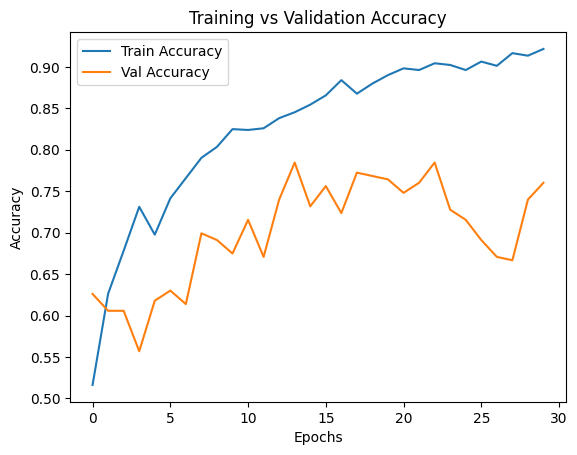

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()
